<a href="https://colab.research.google.com/github/amalmon/Book-recommendation-system/blob/main/Book_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

During the last few decades, with the rise of Youtube, Amazon, Netflix, and many other such web services, recommender systems have taken more and more place in our lives. From e-commerce (suggest to buyers articles that could interest them) to online advertisement (suggest to users the right contents, matching their preferences), recommender systems are today unavoidable in our daily online journeys. In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users (items being movies to watch, text to read, products to buy, or anything else depending on industries).
Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors. The main objective is to create a book recommendation system for users.

Content
The Book-Crossing dataset comprises 3 files.

● Users

Contains the users. Note that user IDs (User-ID) have been anonymized and map to
integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL values.


● Books

Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon website.


● Ratings

Contains the book rating information. Ratings (Book-Rating) are either explicit,
expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit,
expressed by 0.

In [192]:
import numpy as np
import pandas as pd

In [193]:
books=pd.read_csv("/content/drive/MyDrive/Almabetter/capstone projects/CAPSTONE-PROJECT-4-RECOMMENDATION SYSTEM/Books.csv")
users=pd.read_csv("/content/drive/MyDrive/Almabetter/capstone projects/CAPSTONE-PROJECT-4-RECOMMENDATION SYSTEM/Users.csv")
ratings=pd.read_csv("/content/drive/MyDrive/Almabetter/capstone projects/CAPSTONE-PROJECT-4-RECOMMENDATION SYSTEM/Ratings.csv")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**fetching basic idea about data set by first 5 entries**

In [194]:
#head of book data set
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [195]:
#head of users data set
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [196]:
#head of rating data set
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


**figure out structure of data sets**

In [197]:
#for printing shape of all data set
print(books.shape)
print(users.shape)
print(ratings.shape)

(271360, 8)
(278858, 3)
(1149780, 3)


**Searching for null values of data sets (if there any)**

In [198]:
#for total of null values in books data set
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [199]:
#for total of null values in users data set
users.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64



*   Basically, missing values of age column will not much more affect on our final aim recommendation




In [200]:
#for total of null values in ratings data set
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

**finding any duplicate entries are there**

In [201]:
#tot. of duplicate entries in books
books.duplicated().sum()

0

In [202]:
#tot. of duplicate entries in users
users.duplicated().sum()

0

In [203]:
#tot. of duplicate entries in ratings
ratings.duplicated().sum()

0

In [204]:
books.Publisher.unique().size

16808

In [205]:
books['Year-Of-Publication'].unique().size

202

In [206]:
books['Book-Title'].unique().size

242135

In [207]:
books['Book-Author'].unique().size

102024

In [208]:
users.Location.unique().size

57339

### **Pre processing of datasets**



*  droping Null value entries, as a best option for recommendation system.and also there is no possibility to fill with approximate values or it is not much worth here.
*  droping 2 of 3 image url columns and holding large image url column
*  droping user id column which is not needed



In [209]:
#droping null values of books dataset
books.dropna(inplace=True)

In [210]:
#droping columns 'Image-URL-S','Image-URL-M'
books.drop(columns=['Image-URL-S','Image-URL-M'],inplace=True)

In [211]:
books.shape

(271354, 6)

In [212]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271354 entries, 0 to 271359
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271354 non-null  object
 1   Book-Title           271354 non-null  object
 2   Book-Author          271354 non-null  object
 3   Year-Of-Publication  271354 non-null  object
 4   Publisher            271354 non-null  object
 5   Image-URL-L          271354 non-null  object
dtypes: object(6)
memory usage: 14.5+ MB


In [213]:
# merging rating dataset and books dataset
books_with_rating=ratings.merge(books,on='ISBN')

In [214]:
books_with_rating

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
...,...,...,...,...,...,...,...,...
1031124,276688,0517145553,0,Mostly Harmless,Douglas Adams,1995,Random House Value Pub,http://images.amazon.com/images/P/0517145553.0...
1031125,276688,1575660792,7,Gray Matter,Shirley Kennett,1996,Kensington Publishing Corporation,http://images.amazon.com/images/P/1575660792.0...
1031126,276690,0590907301,0,Triplet Trouble and the Class Trip (Triplet Tr...,Debbie Dadey,1997,Apple,http://images.amazon.com/images/P/0590907301.0...
1031127,276704,0679752714,0,A Desert of Pure Feeling (Vintage Contemporaries),Judith Freeman,1997,Vintage Books USA,http://images.amazon.com/images/P/0679752714.0...


In [182]:
books_with_rating.shape

(1031129, 8)


1.   need to create a avrg. rating column
2.   



In [215]:
avrg_df=books_with_rating.groupby('ISBN')['Book-Rating'].mean().reset_index()
avrg_df.columns=['ISBN','Avg.Rating']

In [216]:
avrg_df

,ISBN,Avg.Rating
0,0000913154,8.0
1,0001010565,0.0
2,0001046438,9.0
3,0001046713,0.0
4,000104687X,6.0
...,...,...
270140,B000234N76,0.0
270141,B000234NC6,0.0
270142,B00029DGGO,0.0
270143,B0002JV9PY,0.0


In [217]:
#merging avrg_df and Book_with_rating
books_with_rating=avrg_df.merge(books_with_rating,on='ISBN')

In [186]:
books_with_rating

,ISBN,Avg.Rating,User-ID,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
0,0000913154,8.0,171118,8,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster,http://images.amazon.com/images/P/0000913154.0...
1,0001010565,0.0,86123,0,Mog's Christmas,Judith Kerr,1992,Collins,http://images.amazon.com/images/P/0001010565.0...
2,0001010565,0.0,209516,0,Mog's Christmas,Judith Kerr,1992,Collins,http://images.amazon.com/images/P/0001010565.0...
3,0001046438,9.0,23902,9,Liar,Stephen Fry,0,Harpercollins Uk,http://images.amazon.com/images/P/0001046438.0...
4,0001046713,0.0,196149,0,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers,http://images.amazon.com/images/P/0001046713.0...
...,...,...,...,...,...,...,...,...,...
1031124,B000234N76,0.0,264317,0,Falling Angels,Tracy Chevalier,2001,E P Dutton,http://images.amazon.com/images/P/B000234N76.0...
1031125,B000234NC6,0.0,100906,0,It Must've Been Something I Ate: The Return of...,Jeffrey Steingarten,2002,Knopf,http://images.amazon.com/images/P/B000234NC6.0...
1031126,B00029DGGO,0.0,100088,0,"Good Wife Strikes Back, The",Elizabeth Buchan,0,Viking Adult,http://images.amazon.com/images/P/B00029DGGO.0...
1031127,B0002JV9PY,0.0,179791,0,The Blockade Runners,Jules Verne,0,Digireads.com,http://images.amazon.com/images/P/B0002JV9PY.0...


In [218]:
rating_count_df=books_with_rating['ISBN'].value_counts().reset_index()
rating_count_df.columns=['ISBN','no.of ratings']

In [219]:
rating_count_df

,ISBN,no.of ratings
0,0971880107,2502
1,0316666343,1295
2,0385504209,883
3,0060928336,732
4,0312195516,723
...,...,...
270140,0590661388,1
270141,0590662082,1
270142,059066218X,1
270143,0590664700,1


In [220]:
books_with_rating=rating_count_df.merge(books_with_rating,on='ISBN')


In [221]:
books_with_rating

,ISBN,no.of ratings,Avg.Rating,User-ID,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
0,0971880107,2502,1.019584,276925,0,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...
1,0971880107,2502,1.019584,276939,0,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...
2,0971880107,2502,1.019584,276954,0,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...
3,0971880107,2502,1.019584,277042,2,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...
4,0971880107,2502,1.019584,277157,0,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...
...,...,...,...,...,...,...,...,...,...,...
1031124,0590661388,1,7.000000,14079,7,Teaching the Stories and Poems of Edgar Allan ...,Tara McCarthy,1999,Scholastic,http://images.amazon.com/images/P/0590661388.0...
1031125,0590662082,1,0.000000,278418,0,"A Bug, a Bear, and a Boy: Paint a Picture",David McPhail,1998,Scholastic SeeSaw Book Club,http://images.amazon.com/images/P/0590662082.0...
1031126,059066218X,1,0.000000,278418,0,"A Bug, a Bear, and a Boy Gof for a Ride",David McPhail,1998,Scholastic,http://images.amazon.com/images/P/059066218X.0...
1031127,0590664700,1,7.000000,102460,7,Portraits of Little Women (Amy's Story),Susan Beth Pfeffer,1997,Scholastic,http://images.amazon.com/images/P/0590664700.0...


In [ ]:
#drop userid column

# **E D A**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

**TOP 15 MOST POPULAR AUTHORS**

In [ ]:
authors_value_count=books_with_rating['Book-Author'].value_counts().reset_index()
authors_value_count.columns=['Author','count']
top_author_counts=authors_value_count.sort_values('count',ascending=False)


In [ ]:
top_author_counts

,Author,count
0,Stephen King,10053
1,Nora Roberts,8429
2,John Grisham,6010
3,James Patterson,5845
4,Mary Higgins Clark,4777
...,...,...
68735,Brian Burks,1
68736,Louise Shaffer,1
68737,Gene Lisitzky,1
68738,Robert Burnette,1


[]

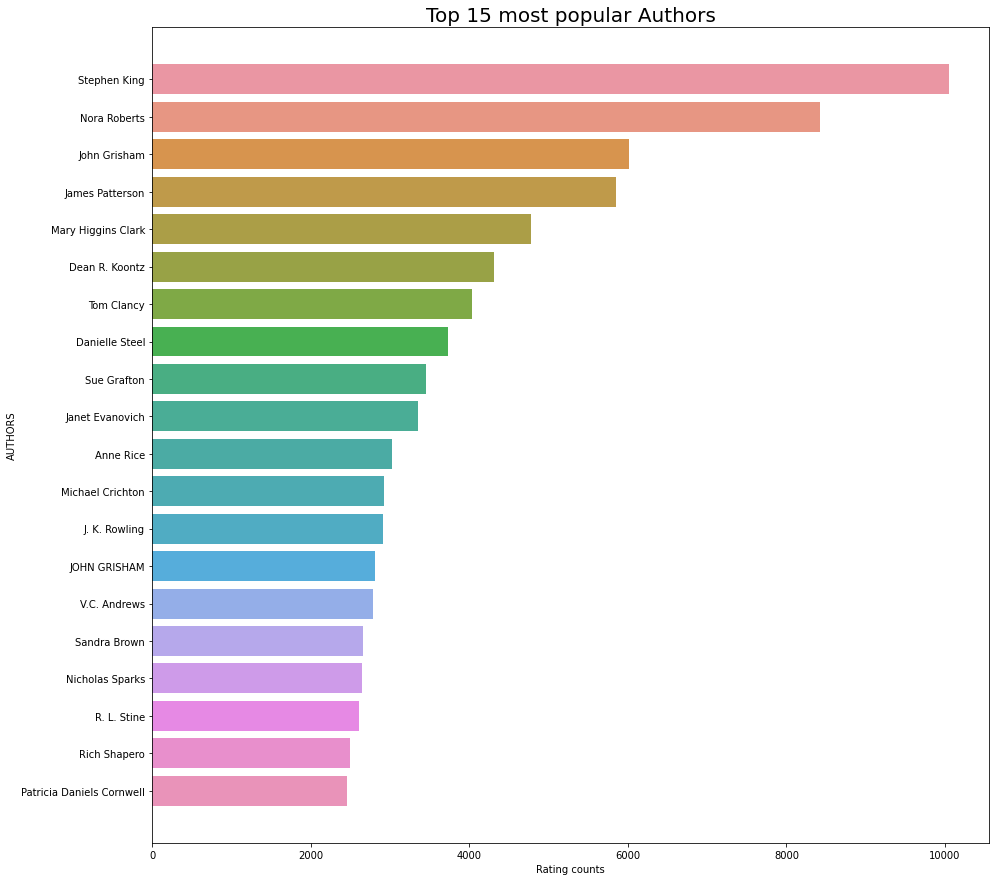

In [ ]:
plt.figure(figsize=(15,15))
sns.barplot(data=top_author_counts.head(20),y='Author',x='count')
plt.ylabel('AUTHORS')
plt.xlabel('Rating counts')
plt.title('Top 15 most popular Authors',fontsize = 20)
plt.plot()

**TOP 25 HIGHEST RATED BOOKS**

In [111]:
top_rated = books_with_rating.sort_values('Avg.Rating', ascending=False)
top_rated = top_rated[:25]

In [138]:
top_rated

,ISBN,Avg.Rating,User-ID,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
97420,0152480099,10.0,15651,10,"Lives of the Writers: Comedies, Tragedies (and...",Kathleen Krull,1994,Harcourt Children's Books,http://images.amazon.com/images/P/0152480099.0...
782100,0764565451,10.0,142801,10,Webster's New World(tm) Dictionary and Thesaur...,Charlton Laird,2002,Webster's New World,http://images.amazon.com/images/P/0764565451.0...
782088,076456465X,10.0,39281,10,Frommer's Arizona 2002,Karl Samson,2001,Frommer,http://images.amazon.com/images/P/076456465X.0...
782085,0764564382,10.0,242299,10,"Frommer's 2002 Cancun, Cozumel &amp; the Yucat...",David Baird,2001,Frommer's,http://images.amazon.com/images/P/0764564382.0...
782053,0764561960,10.0,13850,10,Arizona for Dummies,Edie Jarolim,2000,John Wiley &amp; Sons,http://images.amazon.com/images/P/0764561960.0...
782045,0764561561,10.0,179288,10,Betty Crocker's Bisquick Cookbook,Betty Crocker,2000,Betty Crocker,http://images.amazon.com/images/P/0764561561.0...
782043,0764561472,10.0,22625,10,Webster's New World Pocket Dictionary,Jonathan L. Goldman,2000,Webster's New World,http://images.amazon.com/images/P/0764561472.0...
782038,0764561006,10.0,26084,10,Arco Pcat (Arco Test Preparation Series),Dick R. Gourley,2000,MacMillan Publishing Company.,http://images.amazon.com/images/P/0764561006.0...
782032,0764560670,10.0,23872,10,Creating Web Pages with HTML SimplifiedÂ® 2nd ...,Ruth Maran,1999,John Wiley &amp; Sons,http://images.amazon.com/images/P/0764560670.0...
782028,0764560077,10.0,59172,10,Creating Web Pages Simplified (3-D Visual Series),Ruth Maran,1997,John Wiley &amp; Sons,http://images.amazon.com/images/P/0764560077.0...


[]

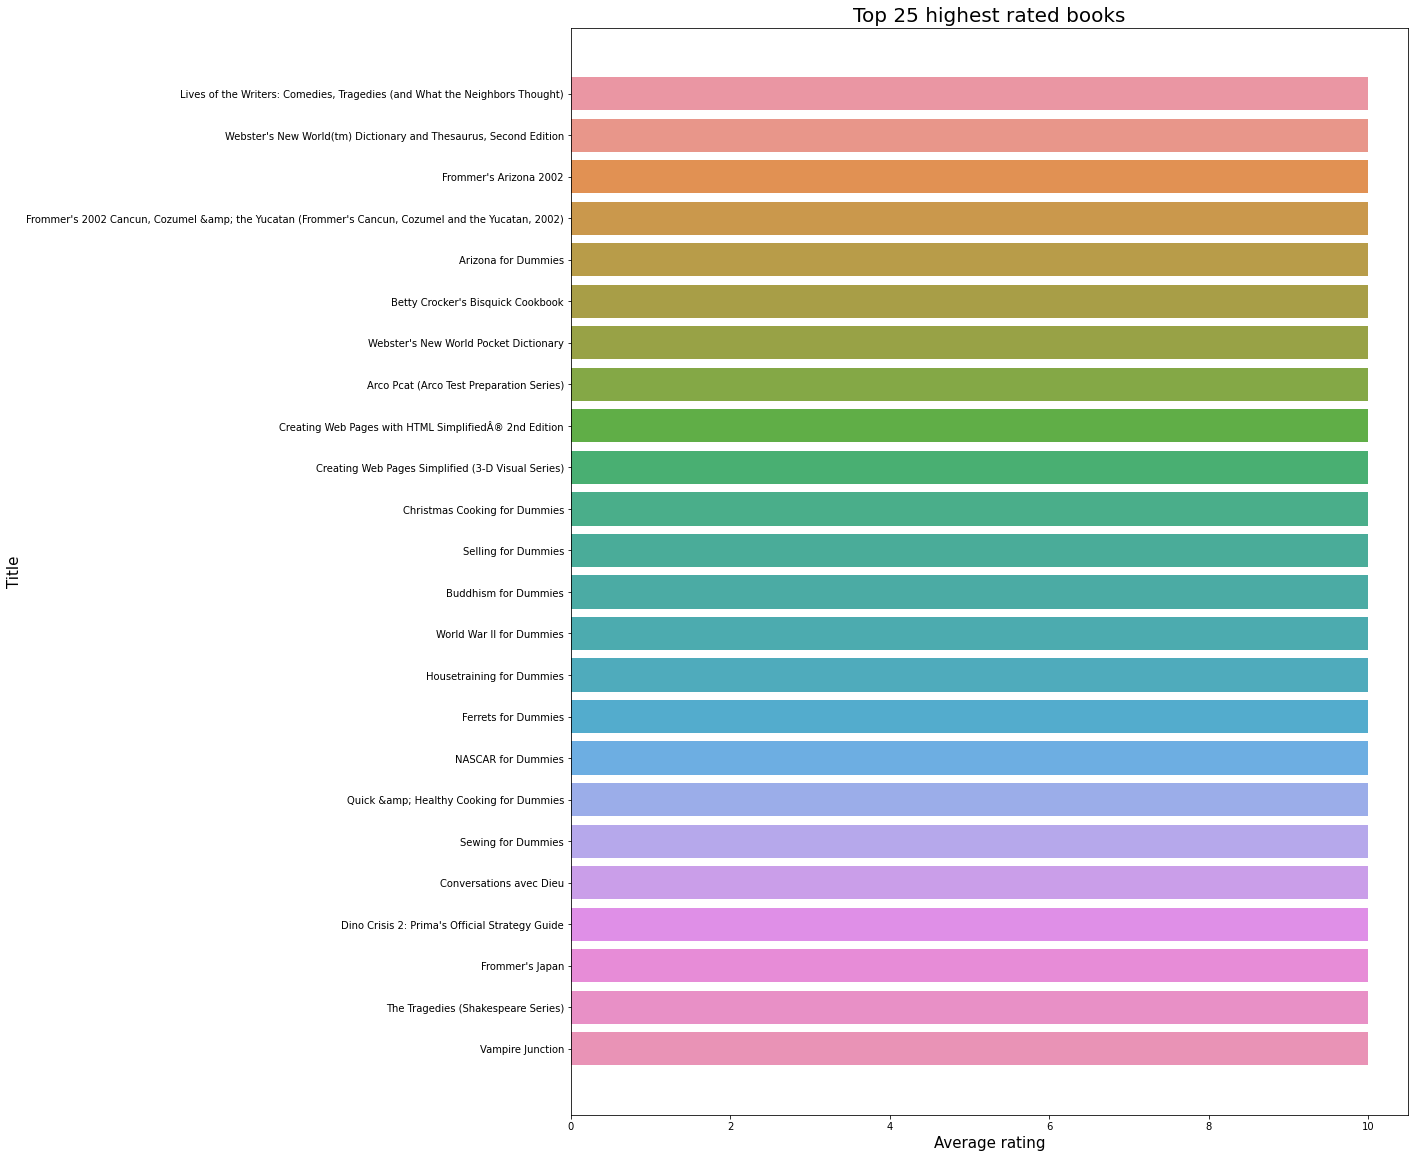

In [113]:
plt.figure(figsize = (15,20))
sns.barplot(data = top_rated, y = 'Book-Title', x = 'Avg.Rating')
plt.ylabel('Title', fontsize = 15)
plt.xlabel('Average rating', fontsize = 15)
plt.title('Top 25 highest rated books', fontsize = 20)

plt.plot()

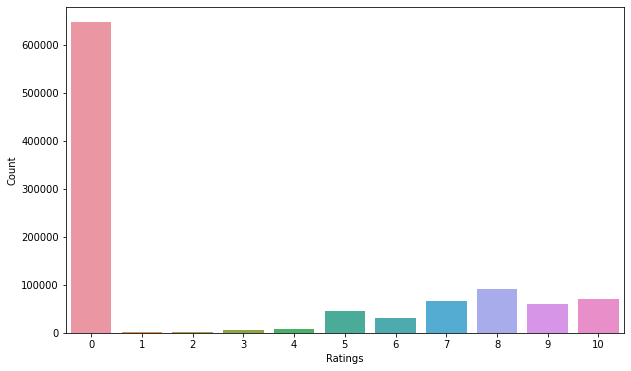

In [234]:
plt.figure(figsize=(10,6))
sns.countplot(data = books_with_rating, x = 'rating')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

**TOP 15 MOST POPULAR BOOKS**

In [ ]:

plt.figure(figsize = (15,8))
sns.barplot(data = top_popular, y = 'Book-Title', x = 'no.of ratings')
plt.ylabel('Title', fontsize = 15)
plt.xlabel(' Rating Count', fontsize = 15)
plt.title('Top 20 most popular books', fontsize = 20)

plt.plot()